# Find Points

In [1]:
import sys
sys.path.append('/mnt/d/codes/Projects/BrainPy/')

import brainpy as bp
import brainpy.math.jax as bm

bp.math.use_backend('jax')
bp.__version__

'1.1.0'

In [2]:
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

## Parameters

In [3]:
# Integration parameters
T = 1.0  # Arbitrary amount time, roughly physiological.
dt = 0.04
num_step = int(T / dt)  # Divide T into this many bins
bval = 0.01  # bias value limit
sval = 0.025  # standard deviation (before dividing by sqrt(dt))

In [4]:
# Optimization hyperparameters
l2reg = 0.00002  # amount of L2 regularization on the weights
num_train = 20000  # Total number of batches to train on.
num_batch = 256  # How many examples in each batch
# Gradient clipping is HUGELY important for training RNNs
# max gradient norm before clipping, clip to this value.
max_grad_norm = 10.0

## Helpers

In [5]:
def plot_examples(num_time, inputs, hiddens, outputs, targets, num_example=1,
                  num_plot=10, start_id=0):
  """Plot some input/hidden/output triplets."""
  plt.figure(figsize=(num_example * 5, 14))
  selected_ids = list(range(start_id, start_id + num_example))

  for i, bidx in enumerate(selected_ids):
    plt.subplot(3, num_example, i + 1)
    plt.plot(inputs[:, bidx], 'k')
    plt.xlim([0, num_time])
    plt.title('Example %d' % bidx)
    if bidx == 0: plt.ylabel('Input Units')

  closeness = 0.25
  for i, bidx in enumerate(selected_ids):
    plt.subplot(3, num_example, num_example + i + 1)
    plt.plot(hiddens[:, bidx, 0:num_plot] + closeness * np.arange(num_plot), 'b')
    plt.xlim([0, num_time])
    if bidx == 0: plt.ylabel('Hidden Units')

  for i, bidx in enumerate(selected_ids):
    plt.subplot(3, num_example, 2 * num_example + i + 1)
    plt.plot(outputs[:, bidx, :], 'r', label='predict')
    plt.plot(targets[:, bidx, :], 'k', label='target')
    plt.xlim([0, num_time])
    plt.xlabel('Time steps')
    plt.legend()
    if bidx == 0: plt.ylabel('Output Units')

  plt.show()

In [6]:
def plot_params(rnn):
  """Plot the parameters. """
  assert isinstance(rnn, GRU)

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.stem(rnn.w_ro.numpy()[:, 0])
  plt.title('W_ro - output weights')

  plt.subplot(232)
  plt.stem(rnn.h0)
  plt.title('h0 - initial hidden state')

  a = bm.concatenate([rnn.w_ir, rnn.w_iz], axis=0)
  b = bm.concatenate([rnn.w_hr, rnn.w_hz], axis=0)
  c = bm.concatenate([a, b], axis=0).numpy()

  plt.subplot(233)
  plt.imshow(c, interpolation=None)
  plt.colorbar()
  plt.title('[W_ir, W_iz, W_hr, W_hz]')

  plt.subplot(234)
  a = bm.concatenate([rnn.w_ia, rnn.w_ha], axis=0).numpy()
  plt.imshow(a, interpolation=None)
  plt.colorbar()
  plt.title('[W_ia, W_ha]')

  plt.subplot(235)
  plt.stem(bm.concatenate([rnn.bz, rnn.br]).numpy())
  plt.title('[bz, br] - recurrent biases')

  plt.subplot(236)
  dFdh = bm.jacobian(rnn.cell)(rnn.h0.value, bm.zeros(rnn.num_input))
  evals, _ = np.linalg.eig(dFdh.numpy())
  x = np.linspace(-1, 1, 1000)
  plt.plot(x, np.sqrt(1 - x ** 2), 'k')
  plt.plot(x, -np.sqrt(1 - x ** 2), 'k')
  plt.plot(np.real(evals), np.imag(evals), '.')
  plt.axis('equal')
  plt.xlabel('Real($\lambda$)')
  plt.ylabel('Imaginary($\lambda$)')
  plt.title('Eigenvalues of $dF/dh(h_0)$')

  plt.show()

In [7]:
def plot_data(num_time, inputs, targets=None, outputs=None, errors=None, num_plot=10):
  """Plot some white noise / integrated white noise examples.

  Parameters
  ----------
  num_time : int
  num_plot : int
  inputs: ndarray
    with the shape of (num_batch, num_time, num_input)
  targets: ndarray
    with the shape of (num_batch, num_time, num_output)
  outputs: ndarray
    with the shape of (num_batch, num_time, num_output)
  errors: ndarray
    with the shape of (num_batch, num_time, num_output)
  """
  num = 1
  if errors is not None: num += 1
  if (targets is not None) or (outputs is not None): num += 1
  plt.figure(figsize=(14, 4 * num))

  # inputs
  plt.subplot(num, 1, 1)
  plt.plot(inputs[:, 0:num_plot, 0])
  plt.xlim([0, num_time])
  plt.ylabel('Noise')

  legends = []
  if outputs is not None:
    plt.subplot(num, 1, 2)
    plt.plot(outputs[:, 0:num_plot, 0])
    plt.xlim([0, num_time])
    legends.append(mlines.Line2D([], [], color='k', linestyle='-', label='predict'))
  if targets is not None:
    plt.subplot(num, 1, 2)
    plt.plot(targets[:, 0:num_plot, 0], '--')
    plt.xlim([0, num_time])
    plt.ylabel("Integration")
    legends.append(mlines.Line2D([], [], color='k', linestyle='--', label='target'))
  if len(legends): plt.legend(handles=legends)

  if errors is not None:
    plt.subplot(num, 1, 3)
    plt.plot(errors[:, 0:num_plot, 0], '--')
    plt.xlim([0, num_time])
    plt.ylabel("|Errors|")

  plt.xlabel('Time steps')
  plt.show()

In [8]:
@partial(bm.jit, dyn_vars=bp.ArrayCollector({'a': bm.random.DEFAULT}),
         static_argnames=('num_batch', 'num_step', 'dt'))
def build_inputs_and_targets(mean, scale, num_batch, num_step, dt):
  """Build white noise input and integration targets."""

  # Create the white noise input.
  sample = bm.random.normal(size=(num_batch,))
  bias = mean * 2.0 * (sample - 0.5)
  samples = bm.random.normal(size=(num_step, num_batch))
  noise_t = scale / dt ** 0.5 * samples
  white_noise_t = bias + noise_t
  inputs_txbx1 = bm.expand_dims(white_noise_t, axis=2)

  # * dt, intentionally left off to get output scaling in O(1).
  integration_txbx1 = bm.expand_dims(bm.cumsum(white_noise_t, axis=0), axis=2)
  targets_txbx1 = bm.zeros_like(integration_txbx1)
  targets_txbx1[-1] = 2.0 * ((integration_txbx1[-1] > 0.0) - 0.5)
  # targets_mask = bm.ones((num_batch, 1)) * (num_step - 1)
  return inputs_txbx1, targets_txbx1

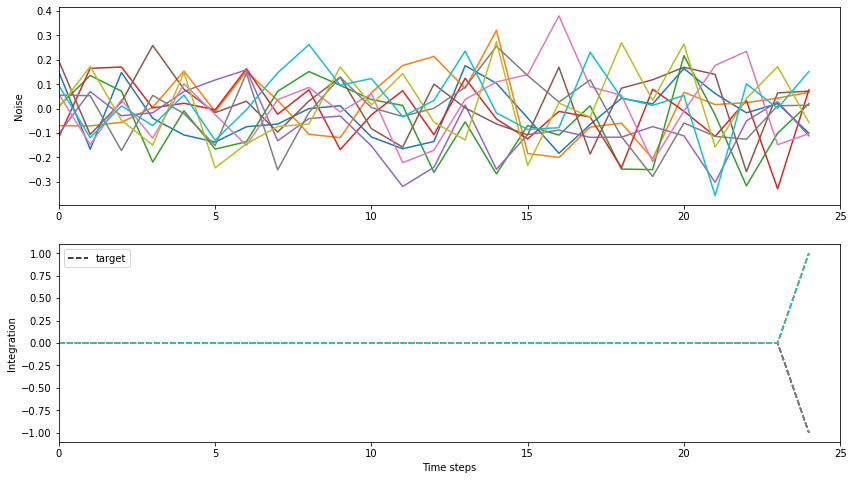

In [9]:
# Plot the example inputs and targets for the RNN.
_ints, _outs = build_inputs_and_targets(bval, sval, num_batch=num_batch,
                                        num_step=num_step, dt=dt)

plot_data(num_step, inputs=_ints, targets=_outs)

## Model

In [10]:
class GRU(bp.DynamicalSystem):
  def __init__(self, num_hidden, num_input, num_output, num_batch,
               g=1.0, l2_reg=0., forget_bias=0.5, **kwargs):
    super(GRU, self).__init__(**kwargs)

    # parameters
    self.l2_reg = l2_reg
    self.num_input = num_input
    self.num_batch = num_batch
    self.num_hidden = num_hidden
    self.num_output = num_output
    self.rng = bm.random.RandomState()
    self.forget_bias = forget_bias

    # recurrent weights
    self.w_iz = bm.TrainVar(self.rng.normal(scale=1 / num_input ** 0.5, size=(num_input, num_hidden)))
    self.w_ir = bm.TrainVar(self.rng.normal(scale=1 / num_input ** 0.5, size=(num_input, num_hidden)))
    self.w_ia = bm.TrainVar(self.rng.normal(scale=1 / num_input ** 0.5, size=(num_input, num_hidden)))
    self.w_hz = bm.TrainVar(self.rng.normal(scale=g / num_hidden ** 0.5, size=(num_hidden, num_hidden)))
    self.w_hr = bm.TrainVar(self.rng.normal(scale=g / num_hidden ** 0.5, size=(num_hidden, num_hidden)))
    self.w_ha = bm.TrainVar(self.rng.normal(scale=g / num_hidden ** 0.5, size=(num_hidden, num_hidden)))
    self.bz = bm.TrainVar(bm.zeros((num_hidden,)))
    self.br = bm.TrainVar(bm.zeros((num_hidden,)))
    self.ba = bm.TrainVar(bm.zeros((num_hidden,)))
    self.h0 = bm.TrainVar(self.rng.normal(scale=0.1, size=(num_hidden,)))

    # output weights
    self.w_ro = bm.TrainVar(self.rng.normal(scale=1 / num_hidden ** 0.5, size=(num_hidden, num_output)))
    self.b_ro = bm.TrainVar(bm.zeros((num_output,)))

    # variables
    self.h = bm.Variable(self.rng.normal(scale=0.1, size=(num_batch, self.num_hidden)))
    self.o = self.h @ self.w_ro + self.b_ro

    # loss
    self.total_loss = bm.Variable(bm.zeros(1))
    self.l2_loss = bm.Variable(bm.zeros(1))
    self.mse_loss = bm.Variable(bm.zeros(1))

  def cell(self, h, x):
    r = bm.sigmoid(x @ self.w_ir + h @ self.w_hr + self.br)
    z = bm.sigmoid(x @ self.w_iz + h @ self.w_hz + self.bz + self.forget_bias)
    a = bm.tanh(x @ self.w_ia + (r * h) @ self.w_ha + self.ba)
    return z * h + (1. - z) * a

  def readout(self, h):
    return h @ self.w_ro + self.b_ro

  def make_update(self, h: bm.JaxArray, o: bm.JaxArray):
    def update(x):
      h.value = self.cell(h, x)
      o.value = self.readout(h)

    return update

  def predict(self, xs):
    self.h[:] = self.h0
    f = bm.easy_scan(self.make_update(self.h, self.o),
                     dyn_vars=self.vars().unique(),
                     out_vars=[self.h, self.o])
    return f(xs)

  def loss(self, xs, ys):
    hs, os = self.predict(xs)
    l2 = self.l2_reg * bm.losses.l2_norm(self.train_vars().dict()) ** 2
    mse = bm.losses.mean_squared_error(os[-1], ys[-1])
    total = l2 + mse
    self.total_loss[0] = total
    self.l2_loss[0] = l2
    self.mse_loss[0] = mse
    return total

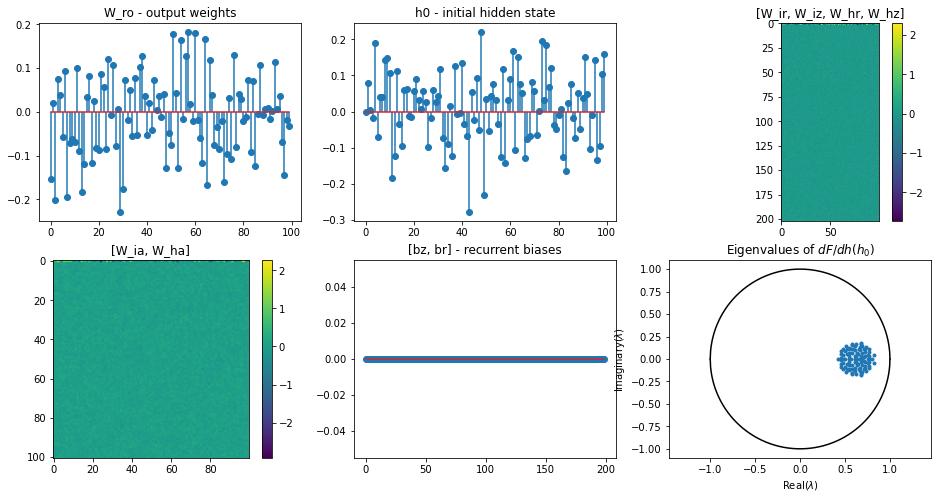

In [11]:
net = GRU(num_input=1, num_hidden=100, num_output=1, num_batch=num_batch, l2_reg=l2reg)

plot_params(net)

In [12]:
lr = bm.optimizers.exponential_decay(lr=0.04, decay_steps=1, decay_rate=0.9999)
optimizer = bm.optimizers.Adam(lr=lr, train_vars=net.train_vars(), eps=1e-1)


@bm.jit
@bm.function(nodes=(net, optimizer))
def train(inputs, targets):
  grad_f = bm.grad(net.loss, dyn_vars=net.vars(), grad_vars=net.train_vars(), return_value=True)
  grads, loss = grad_f(inputs, targets)
  clipped_grads = bm.clip_by_norm(grads, max_grad_norm)
  optimizer.update(clipped_grads)
  return loss

## Training

In [13]:
t0 = time.time()
train_losses = {'total': [], 'l2': [], 'mse': []}
for i in range(num_train):
  _ins, _outs = build_inputs_and_targets(bval, sval, num_batch=num_batch, num_step=num_step, dt=dt)
  loss = train(inputs=_ins, targets=_outs)
  if (i + 1) % 200 == 0:
    print(f"Run batch {i} in {time.time() - t0:0.3f} s, learning rate: "
          f"{lr(optimizer.step[0]):.5f}, training loss {loss:0.4f}")
    train_losses['total'].append(net.total_loss[0])
    train_losses['l2'].append(net.l2_loss[0])
    train_losses['mse'].append(net.mse_loss[0])

Run batch 199 in 11.301 s, learning rate: 0.03921, training loss 0.2942
Run batch 399 in 19.776 s, learning rate: 0.03843, training loss 0.1890
Run batch 599 in 28.202 s, learning rate: 0.03767, training loss 0.1915
Run batch 799 in 36.798 s, learning rate: 0.03692, training loss 0.1275
Run batch 999 in 45.471 s, learning rate: 0.03619, training loss 0.1182
Run batch 1199 in 54.109 s, learning rate: 0.03548, training loss 0.1049
Run batch 1399 in 62.600 s, learning rate: 0.03477, training loss 0.0656
Run batch 1599 in 71.299 s, learning rate: 0.03408, training loss 0.1231
Run batch 1799 in 79.917 s, learning rate: 0.03341, training loss 0.1291
Run batch 1999 in 88.517 s, learning rate: 0.03275, training loss 0.0827
Run batch 2199 in 97.428 s, learning rate: 0.03210, training loss 0.1014
Run batch 2399 in 106.122 s, learning rate: 0.03146, training loss 0.0872
Run batch 2599 in 114.932 s, learning rate: 0.03084, training loss 0.1421
Run batch 2799 in 124.322 s, learning rate: 0.03023, t

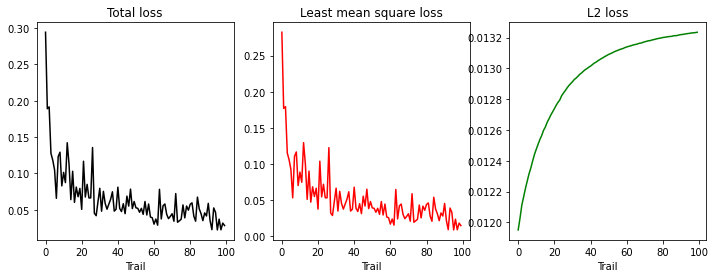

In [14]:
# Show the loss through training.
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(train_losses['total'], 'k')
plt.title('Total loss')
plt.xlabel('Trail')

plt.subplot(132)
plt.plot(train_losses['mse'], 'r')
plt.title('Least mean square loss')
plt.xlabel('Trail')

plt.subplot(133)
plt.plot(train_losses['l2'], 'g')
plt.title('L2 loss')
plt.xlabel('Trail')
plt.show()

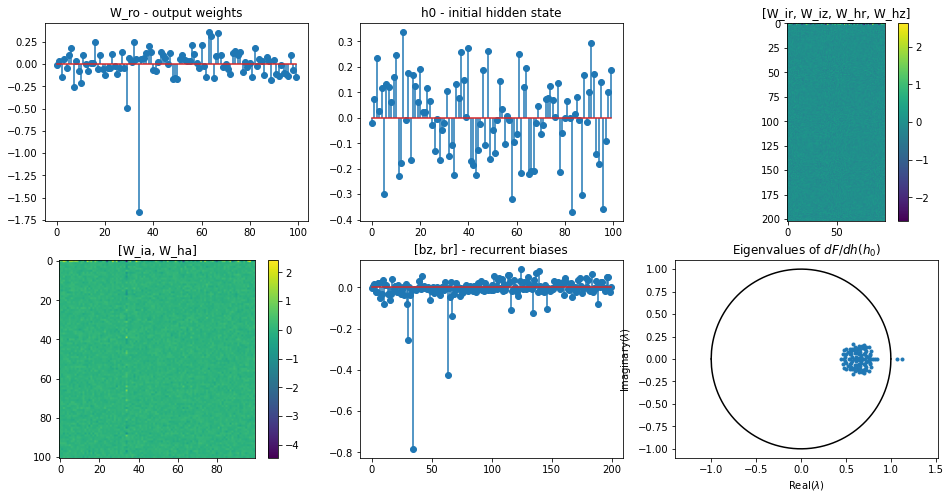

In [15]:
# show the trained weights
plot_params(net)

## Testing

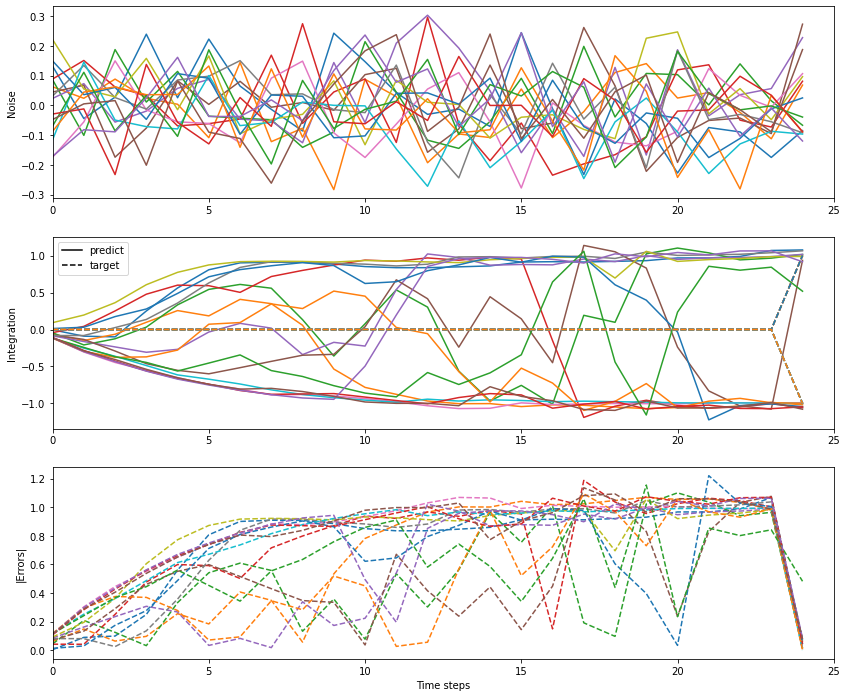

In [16]:
inputs, targets = build_inputs_and_targets(bval, sval, num_batch=num_batch, num_step=num_step, dt=dt)
hiddens, outputs = net.predict(inputs)

plot_data(num_step, inputs=inputs, targets=targets, outputs=outputs, errors=np.abs(targets - outputs), num_plot=16)

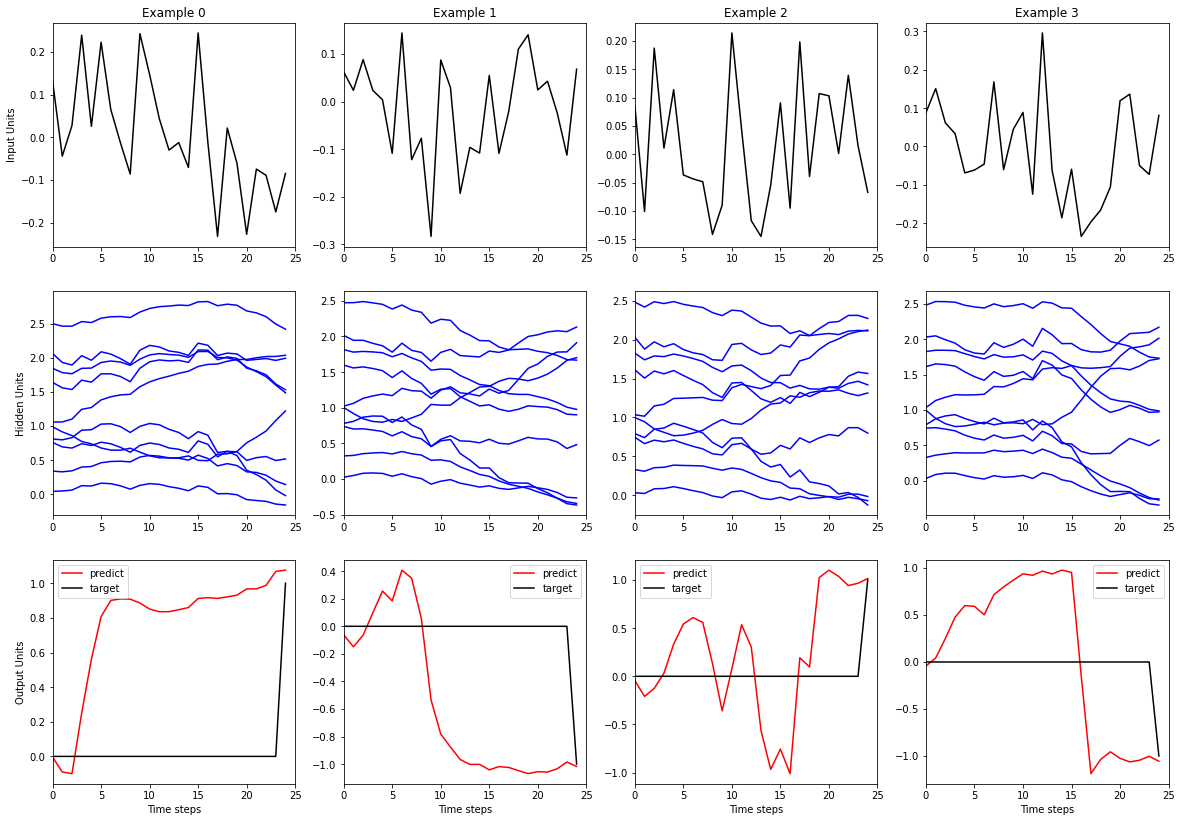

In [17]:
plot_examples(num_step, inputs=inputs, targets=targets, outputs=outputs, hiddens=hiddens, num_example=4)

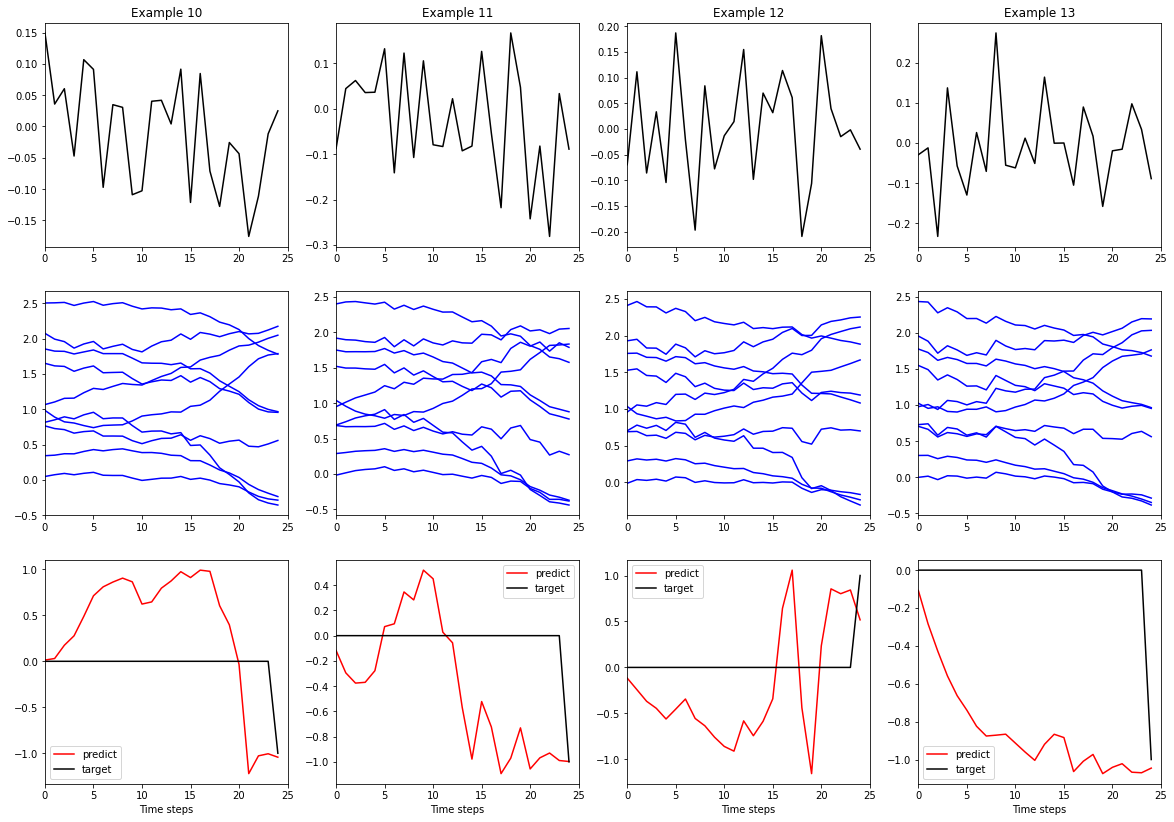

In [18]:
plot_examples(num_step, inputs=inputs, targets=targets, outputs=outputs, hiddens=hiddens, num_example=4, start_id=10)

## Fixed point analysis

Now that we've trained up this GRU to decide whether or not the perfect integral of the input is positive or negative, we can analyze the system via fixed point analysis.

The update rule of the GRU cell from the current state to the next state can be computed by：

In [19]:
f_cell = lambda h: net.cell(h, bm.zeros(net.num_input))

The function to determine the fixed point loss is given by the squared error of a point $(h - F(h))^2$:

In [20]:
f_loss = lambda h: bm.mean(h - net.cell(h, bm.zeros(net.num_input))) ** 2

Let's try to find the fixed points given the initial states.

In [21]:
finder = bp.analysis.numeric.FixedPointFinder(
  f_cell=f_cell,
  f_loss=f_loss,
  tol_outlier=1.,
  tol_opt=1e-6,
  tol_speed=1e-6,
  tol_unique=0.03,
  opt_setting=dict(method=bm.optimizers.Adam,
                   lr=bm.optimizers.exponential_decay(0.2, 1, 0.9999),
                   eps=1e-8)
)
fps, fp_losses, keep_ids, opt_losses = finder.find_fixed_points(
  candidates=hiddens.reshape((-1, net.num_hidden)))

Optimizing to find fixed points:
    Batches 1-100 in 1.47 sec, Training loss 0.0000042291
    Stop optimization as mean training loss 0.0000042291 is below tolerance 0.0000100000.
Excluding fixed points with squared speed above tolerance 0.00001:
    Kept 5735/6400 fixed points with tolerance under 1e-05.
Excluding non-unique fixed points:
    Kept 5449/5735 unique fixed points with uniqueness tolerance 0.025.
Excluding outliers:
    Kept 5449/5449 fixed points with within outlier tolerance 1.0.
Sorting fixed points with slowest speed first.


### Verify fixed points

Plotting the quality of the fixed points.

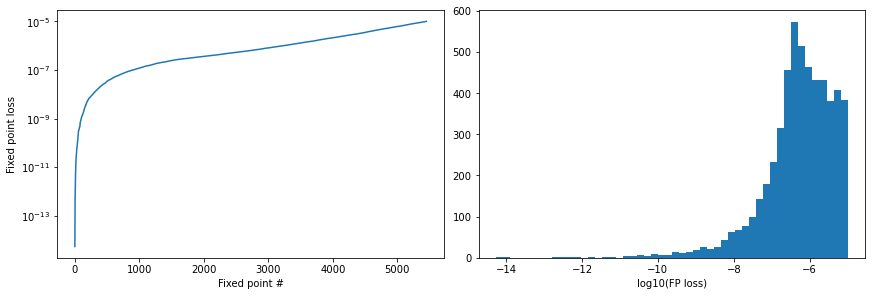

In [22]:
fig, gs = bp.visualize.get_figure(1, 2, 4, 6)

fig.add_subplot(gs[0, 0])
plt.semilogy(fp_losses)
plt.xlabel('Fixed point #')
plt.ylabel('Fixed point loss')

fig.add_subplot(gs[0, 1])
plt.hist(np.log10(bm.vmap(f_loss)(fps)), 50)
plt.xlabel('log10(FP loss)')
plt.show()

Let's run the system starting at these fixed points, without input, and make sure the system is at equilibrium there. Note one can have fixed points that are very unstable, but that does not show up in this example.

In [23]:
num_example = 4
idxs = np.random.randint(0, len(fps), num_example)
check_h = bm.Variable(fps[idxs])
check_o = bm.Variable(bm.zeros((num_example, net.num_output)))

f_check_update = bm.easy_scan(net.make_update(check_h, check_o),
                              dyn_vars=[net.w_ir, net.w_hr, net.br, 
                                        net.w_iz, net.w_hz, net.bz, 
                                        net.w_ia, net.w_ha, net.ba, 
                                        net.w_ro, net.b_ro, 
                                        check_h, check_o],
                              out_vars=[check_h, check_o])

_ins = bm.zeros((num_step, num_example, net.num_input))
_outs = bm.zeros((num_step, num_example, net.num_output))
slow_hiddens, slow_outputs = f_check_update(_ins)

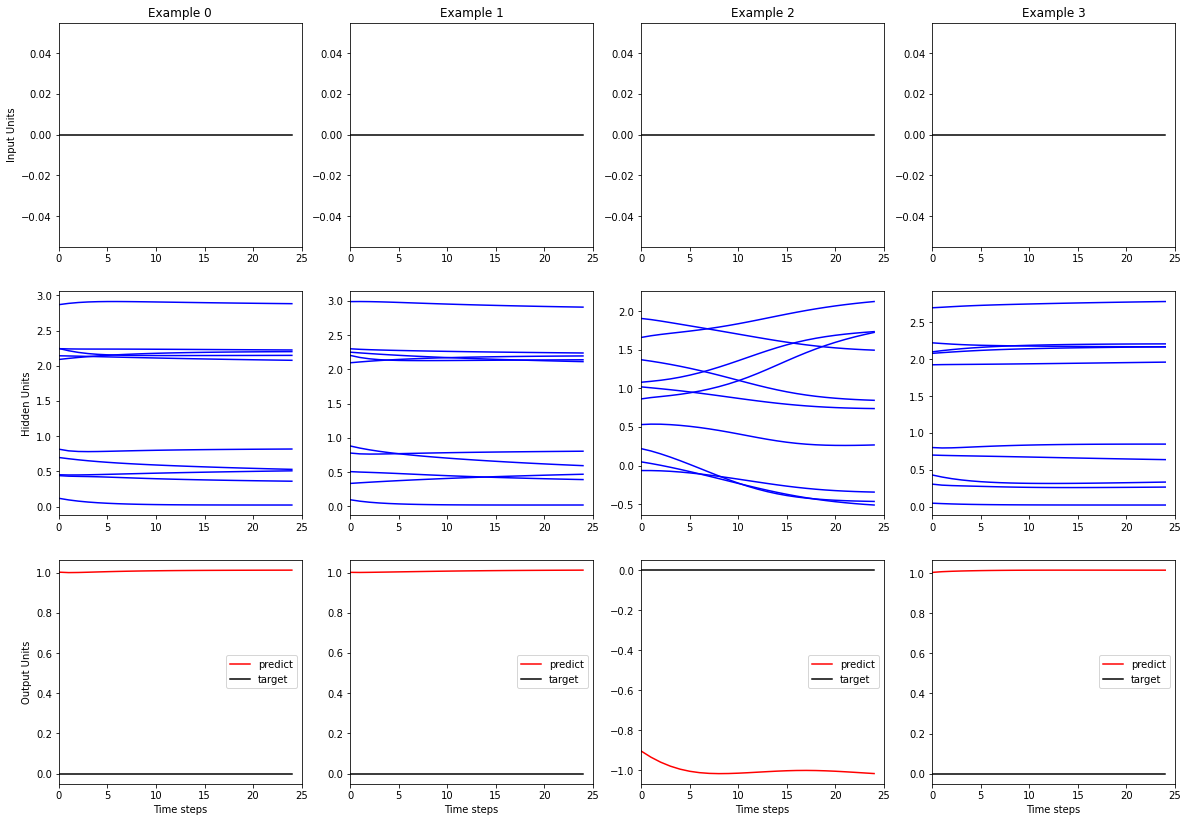

In [24]:
plot_examples(num_step, inputs=_ins, targets=_outs, outputs=slow_outputs, 
              hiddens=slow_hiddens, num_example=num_example)

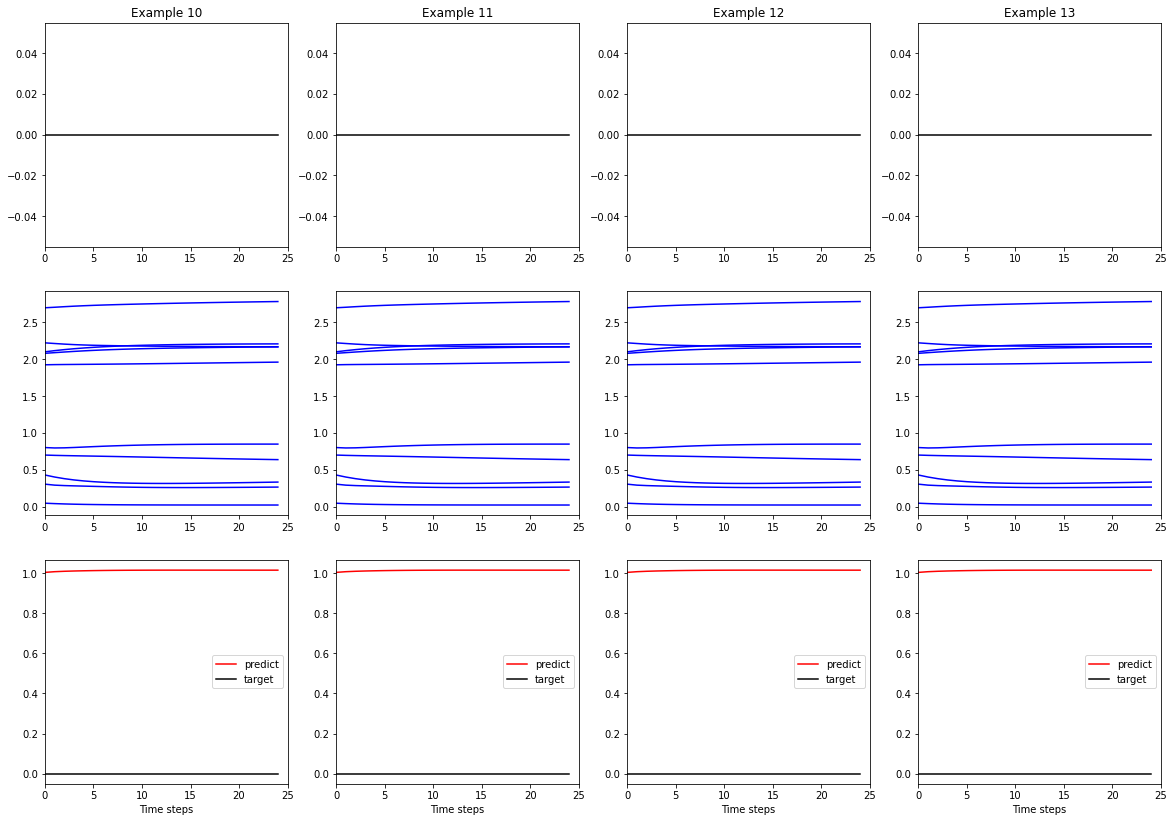

In [25]:
plot_examples(num_step, inputs=_ins, targets=_outs, outputs=slow_outputs, 
              hiddens=slow_hiddens, num_example=num_example, start_id=10)

Try to get a nice representation of the line using the fixed points.

In [26]:
# Sort the best fixed points by projection onto the readout.
fp_readouts = np.squeeze(net.readout(fps))
fp_ro_sidxs = np.argsort(fp_readouts)
sorted_fp_readouts = fp_readouts[fp_ro_sidxs]
sorted_fps = fps[fp_ro_sidxs]

downsample_fps = 6 # Use this if too many fps
sorted_fp_readouts = sorted_fp_readouts[0:-1:downsample_fps]
sorted_fps = sorted_fps[0:-1:downsample_fps]

### Visualize fixed points

Now, through a series of plots and dot products, we will see how the GRU solved the binary decision task. First we plot the fixed points, the fixed point candidates that the fixed point optimization was seeded with.

* Black shows the original candidate point, the colored stars show the fixed point, where the color of the fixed point is the projection onto the readout vector and the size is commensurate with how slow it is (slower is larger).

* So in this example, we see that the fixed point structure implements an approximate line attractor, which is the one-dimensional manifold likely used to integrate the white noise and ultimately lead to the decision.

* Note also the shape of the manifold relative to the color.  The color is the based on the readout value of the fixed point, so it appears that there may be three parts to the line attractor.  The middle and two sides.  The two sides may be integrating, even though the the readout would be +1 or -1.

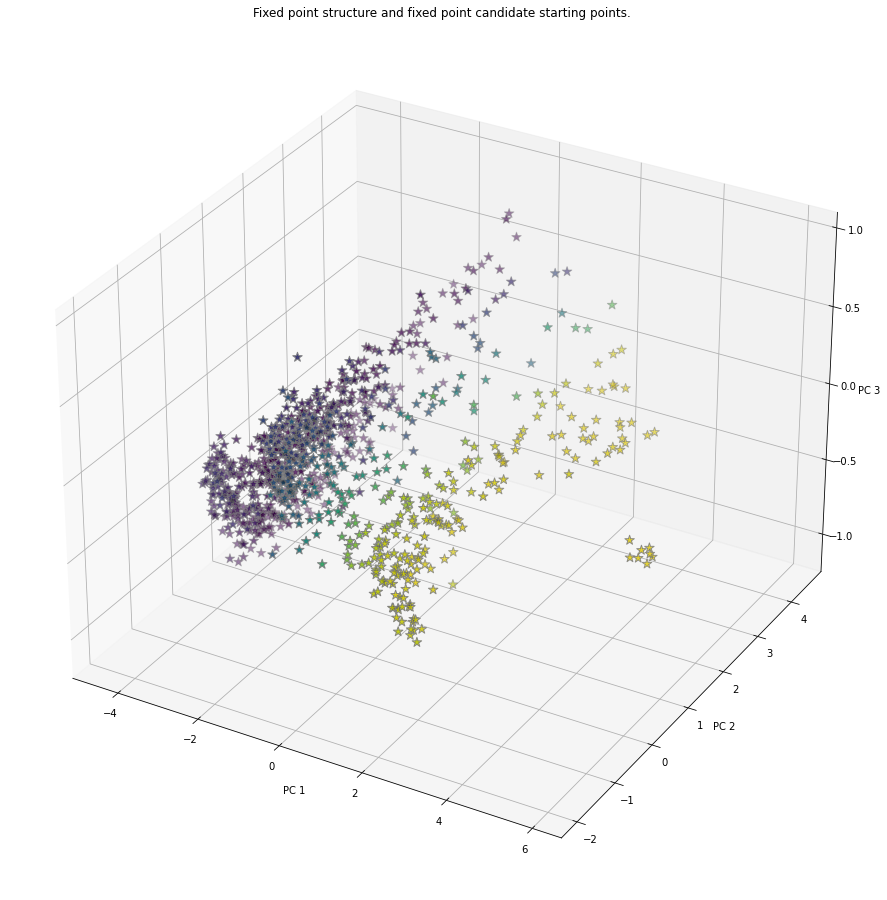

In [27]:
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

fp_candidates = hiddens.reshape((-1, net.num_hidden))
pca = PCA(n_components=3).fit(fp_candidates)


max_fps_to_plot = 1000
sizes = [100, 500]
h_pca = pca.transform(fp_candidates[keep_ids])
emax = h_pca.shape[0] if h_pca.shape[0] < max_fps_to_plot else max_fps_to_plot

alpha = 0.01
ax.scatter(h_pca[0:emax,0], h_pca[0:emax,1], h_pca[0:emax,2], color=[0, 0, 0, 0.1], s=10)

hstars = np.reshape(fps, (-1, net.num_hidden))
hstar_pca = pca.transform(hstars)
color = np.squeeze(net.readout(hstars))
color = np.where(color > 1.0, 1.0, color)
color = np.where(color < -1.0, -1.0, color)
color = (color + 1.0) / 2.0

marker_style = dict(marker='*', s=100, edgecolor='gray')
ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], c=color[0:emax], **marker_style);

for eidx in range(emax):
    ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]],
              [h_pca[eidx,1], hstar_pca[eidx,1]],
              [h_pca[eidx,2], hstar_pca[eidx,2]], c=[0, 0, 1, alpha])
        
plt.title('Fixed point structure and fixed point candidate starting points.')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

It's worth taking a look at the fixed points, and the trajectories started at the fixed points, without any input, all plotted in the 3D PCA space.

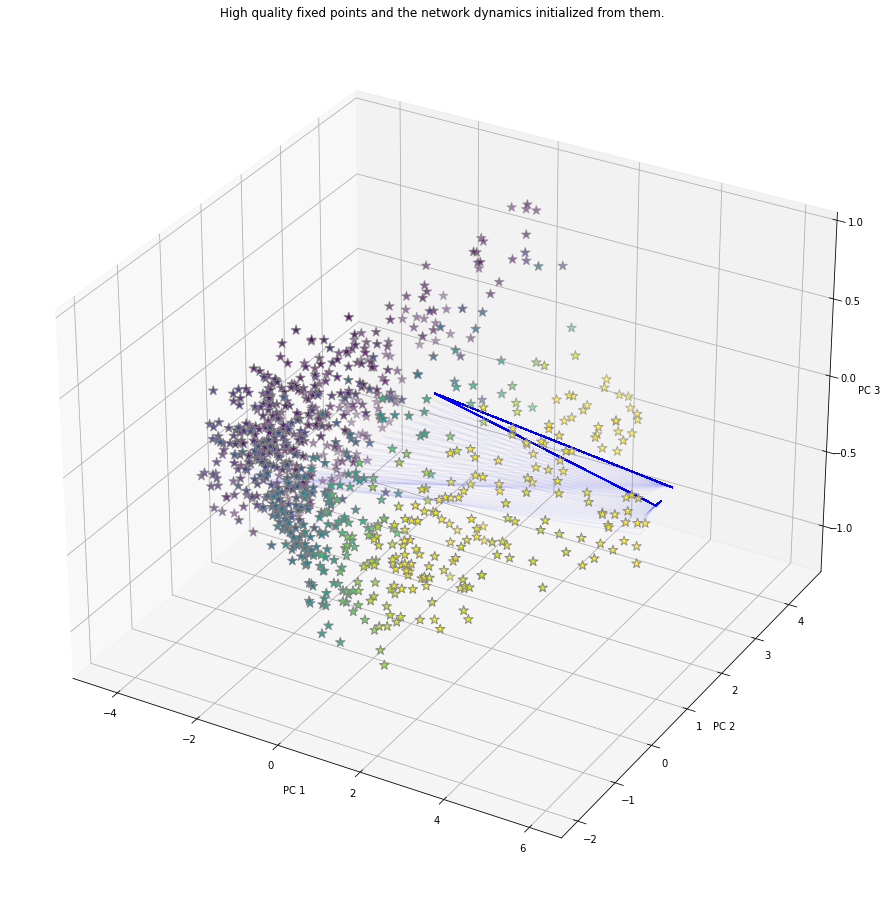

In [28]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

_hiddens = fp_candidates[keep_ids]
all_hiddens = np.reshape(_hiddens, (-1, net.num_hidden))
pca = PCA(n_components=3).fit(fp_candidates)

alpha = 0.05
emax = len(sorted_fps)
for eidx in range(emax):
    h_pca = pca.transform(slow_hiddens[eidx, :, :])
    ax.plot3D(h_pca[:,0], h_pca[:,1], h_pca[:,2], c=[0, 0, 1, alpha])
        
size = 100
hstar_pca = pca.transform(sorted_fps)
color = np.squeeze(net.readout(sorted_fps))
color = np.where(color > 1.0, 1.0, color)
color = np.where(color < -1.0, -1.0, color)
color = (color + 1.0) / 2.0    
marker_style = dict(marker='*', s=size, edgecolor='gray')

ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
           c=color[0:emax], **marker_style)

plt.title('High quality fixed points and the network dynamics initialized from them.')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

### Analysis of linearized systems around the fixed points

Glancing up at the trained parameters plot, you can see the eigenvalues of the GRU linearized around the trained initial condition, $h_0$. These eigenvalues are plotted in the complex plane.  There is one eigenvalue very close to $(1,0)$ in the complex plane, this means the system can integrate.  The rest of the eigenvalues are within the unit circle, meaning they are stable, decaying modes.  For this example, we can safely ignore all the modes except the first one.

Below, we plot the top eigenvalues as a function of the location on the readout. The top eigenvalue is very close to $(1,0)$ across the line readout.

In [29]:
jacobians = finder.compute_jacobians(sorted_fps)
eig_decomps = finder.decompose_eigenvalues(jacobians)

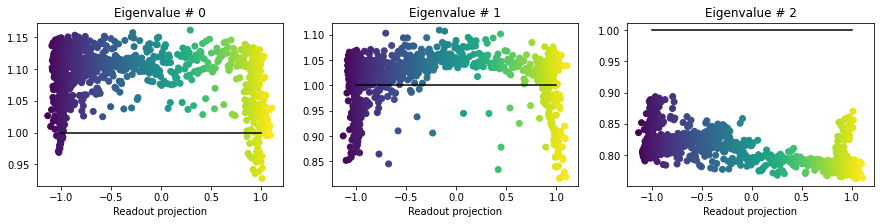

In [30]:
neigs = 3
plt.figure(figsize=(neigs*5, 3))
for eidx in range(neigs):
    max_eigs = []
    for decomp in eig_decomps:
        evals = decomp['eig_values']
        max_eigs.append(np.real(evals[eidx]))

    max_eigs = np.array(max_eigs)

    plt.subplot(1,neigs,eidx+1)
    plt.scatter(sorted_fp_readouts, max_eigs, c=sorted_fp_readouts);
    plt.plot([-1,1,], [1, 1], 'k')
    plt.axis('tight')
    plt.title('Eigenvalue # ' + str(eidx))
    plt.xlabel('Readout projection')
plt.show()

Another major quantity of interest is what the right and left eigenvectors are doing.

Here, we will comment exclusively on the right eigenvectors.  The right eigenvectors give the direction in which the system will integrate input.  Projecting the right eigenvectors on the readout of the GRU is a very natural thing to do then, because it shows when input is integrated to move the readout (if the readout of the right eigenvector and the readout is high), vs. when the input is integrated and does not change the readout projection (if the readout of the right eigenvector and the readout is very small, basically orthogonal).

Notice that the projection between the right maximal eigenvalue and the readout varies as a function of the location of the fixed point.  This is very curious and points to how the nonlinear GRU is solving the binary decision task.

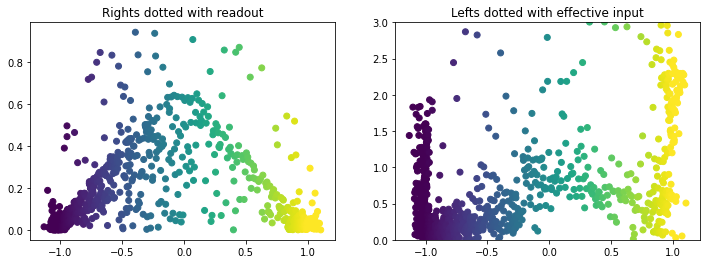

In [31]:
ldots = []
rdots = []
rdotla = []

color = np.squeeze(net.readout(sorted_fps))
color = np.where(color > 1.0, 1.0, color)
color = np.where(color < -1.0, -1.0, color)
color = (color + 1.0) / 2.0

nfps = len(sorted_fps)
dfdx = bm.jit(bm.vmap(bm.jacrev(net.cell, argnums=1)))
val_of_dfdx = dfdx(sorted_fps, np.ones((nfps, 1)))
for jidx in range(nfps):
    r0 = np.real(eig_decomps[jidx]['R'][:, 0])
    rdots.append(np.dot(r0, net.w_ro))
    l0 = np.real(eig_decomps[jidx]['L'][:, 0])
    ldots.append(np.dot(l0, val_of_dfdx[jidx]))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(sorted_fp_readouts, np.abs(rdots), c=color)
plt.title('Rights dotted with readout')
plt.subplot(122)
plt.scatter(sorted_fp_readouts, np.abs(ldots), c=color)
plt.title('Lefts dotted with effective input')
plt.ylim([0, 3])
plt.show()

Three other sets of dot products give a nearly complete story. 

1. Dot product of fixed points with the readout as a function of where the fixed point is on the line attractor.  They are either very high, or very low.  
2. Dot product of the local direction of the line attractor (the tangent of the line) and readout.  This shows that most of the line attractor motion is orthogonal to the readout, thus implementing something approximating a decision boundary. 
3. Dot product of the right maximal eigenvector with the local direction of the line attractor. While a bit messy, this shows that the direction local integration, as given by the right maximal eigenvector, is always lined up with the line attractor tangent, _regardless_ of the projection onto the readout. 

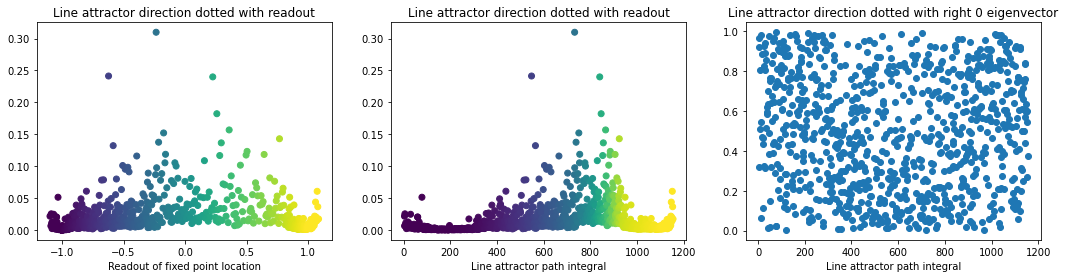

In [32]:
rdotsla = []
la_dots = []
la_locs = []
la_path_int = [0.0]
naround = 3
la_last = sorted_fps[naround-1,:]
for jidx in range(naround, nfps-naround):
    idxs = np.arange(jidx-naround, jidx+naround+1)
    v1 = sorted_fps[idxs[0],:]
    v2 = sorted_fps[idxs[-1],:]
    la = (v2-v1)/np.linalg.norm(v2-v1) # approximate line attractor direction.
    la_dots.append(np.dot(la, net.w_ro))
    la_locs.append(np.squeeze(net.readout(np.mean(sorted_fps[idxs,:], axis=0))))
    la_path_int.append(la_path_int[-1] + np.linalg.norm(la-la_last))
    la_last = la

    r0 = np.real(eig_decomps[jidx]['R'][:, 0])
    rdotsla.append(np.abs(np.dot(r0, la.T)))

la_dots = np.array(la_dots)
la_locs = np.array(la_locs)
la_path_int = np.array(la_path_int)
la_path_int = la_path_int[1:]

color2 = color[naround: -naround]

plt.figure(figsize=(18,4))
plt.subplot(131)
plt.scatter(la_locs, la_dots, c=color2)
plt.xlabel('Readout of fixed point location')
plt.title('Line attractor direction dotted with readout')
plt.subplot(132)
plt.scatter(la_path_int, la_dots, c=color2)
plt.xlabel('Line attractor path integral')
plt.title('Line attractor direction dotted with readout')
plt.subplot(133)
plt.scatter(la_path_int, rdotsla)
plt.xlabel('Line attractor path integral')
plt.title('Line attractor direction dotted with right 0 eigenvector')
plt.show()